In [47]:
import numpy as np
from easydict import EasyDict
from collections import defaultdict
from sksurv.metrics import concordance_index_ipcw

import torch # For building the networks 
import torchtuples as tt # Some useful functions

from pycox.models import PCHazard


In [48]:
np.random.seed(1234)
_ = torch.manual_seed(123)

In [49]:
from survtrace.dataset import load_data

# define the setup parameters
pc_hazard_config = EasyDict({
    'data': 'metabric',
    'horizons': [.25, .5, .75],
    'batch_size': 64,
    'learning_rate': 0.01,
    'epochs': 50,
    'hidden_size': 32
})
pc_hazard_config = EasyDict({
    'data': 'support',
    'horizons': [.25, .5, .75],
    'batch_size': 128,
    'learning_rate': 0.01,
    'epochs': 50,
    'hidden_size': 32
})
pc_hazard_config = EasyDict({
    'data': 'seer',
    'horizons': [.25, .5, .75],
    'batch_size': 1024,
    'learning_rate': 0.01,
    'epochs': 100,
    'hidden_size': 32
})
event_to_censor = 'event_1'
event_to_keep = '0' if event_to_censor.split('_')[1] == '1' else '1'
event_to_keep = 'event_' + event_to_keep


# load data
df, df_train, df_y_train, df_test, df_y_test, df_val, df_y_val = load_data(pc_hazard_config)

# censor event
censor_event = lambda df: df.drop(event_to_censor, axis=1).rename(columns={event_to_keep: 'event'})

df = censor_event(df)
df_y_train = censor_event(df_y_train)
df_y_val = censor_event(df_y_val)
df_y_test = censor_event(df_y_test)


x_train = np.array(df_train, dtype='float32')
x_val = np.array(df_val, dtype='float32')
x_test = np.array(df_test, dtype='float32')

y_df_to_tuple = lambda df: tuple([np.array(df['duration'], dtype='int64'), np.array(df['event'], dtype='float32'), np.array(df['proportion'], dtype='float32')])

y_train = y_df_to_tuple(df_y_train)
y_val = y_df_to_tuple(df_y_val)

In [50]:
pc_hazard_config

{'data': 'seer',
 'horizons': [0.25, 0.5, 0.75],
 'batch_size': 1024,
 'learning_rate': 0.01,
 'epochs': 100,
 'hidden_size': 32,
 'num_event': 2,
 'labtrans': <survtrace.utils.LabelTransform at 0x7fbd7a6e68d0>,
 'num_numerical_feature': 4,
 'num_categorical_feature': 14,
 'num_feature': 18,
 'vocab_size': 185,
 'duration_index': array([  0.,  17.,  34.,  58., 121.]),
 'out_feature': 4}

In [51]:
hidden_size = pc_hazard_config.hidden_size
batch_norm = True
dropout = 0.1

net = torch.nn.Sequential(
    torch.nn.Linear(pc_hazard_config.num_feature, hidden_size),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(hidden_size),
    torch.nn.Dropout(0.1),
    
    torch.nn.Linear(hidden_size, hidden_size),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(hidden_size),
    torch.nn.Dropout(0.1),
    
    torch.nn.Linear(hidden_size, pc_hazard_config.out_feature)
)

In [52]:
model = PCHazard(net, tt.optim.Adam, duration_index=np.array(pc_hazard_config['duration_index'], dtype='float32'))
model.optimizer.set_lr(pc_hazard_config.learning_rate)

In [53]:
callbacks = [tt.callbacks.EarlyStopping(patience=5)]
log = model.fit(x_train, y_train, pc_hazard_config.batch_size, pc_hazard_config.epochs, callbacks, val_data=tuple([x_val, y_val]))


0:	[2s / 2s],		train_loss: 0.6240,	val_loss: 3.4523
1:	[2s / 4s],		train_loss: 0.5200,	val_loss: 1.2993
2:	[2s / 6s],		train_loss: 0.5168,	val_loss: 0.5596
3:	[2s / 8s],		train_loss: 0.5158,	val_loss: 15.3204
4:	[2s / 10s],		train_loss: 0.5152,	val_loss: 3.6082
5:	[2s / 12s],		train_loss: 0.5146,	val_loss: 0.9026
6:	[2s / 15s],		train_loss: 0.5145,	val_loss: 1.3569
7:	[2s / 17s],		train_loss: 0.5138,	val_loss: 1.7613


<AxesSubplot:>

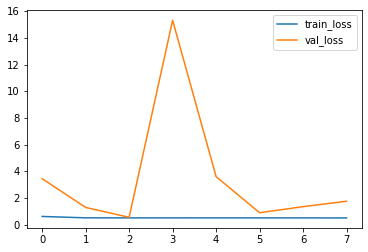

In [54]:
log.plot()

In [55]:
class Evaluator:
    def __init__(self, df, train_index):
        '''the input duration_train should be the raw durations (continuous),
        NOT the discrete index of duration.
        '''
        self.df_train_all = df.loc[train_index]

    def eval_single(self, model, test_set, config, val_batch_size=None):
        df_train_all = self.df_train_all
        get_target = lambda df: (df['duration'].values, df['event'].values)
        durations_train, events_train = get_target(df_train_all)
        print('durations_train', durations_train)
        et_train = np.array([(events_train[i], durations_train[i]) for i in range(len(events_train))],
                        dtype = [('e', bool), ('t', float)])
        print('et_train', et_train)
        times = config['duration_index'][1:-1]
        print('times', times)
        horizons = config['horizons']

        df_test, df_y_test = test_set
        surv = model.predict_surv_df(df_test, batch_size=val_batch_size)
        risk = np.array((1 - surv).transpose())
        print('risk', risk)
        
        durations_test, events_test = get_target(df_y_test)
        print('durations_test', durations_test)
        print('events_test', events_test)
        et_test = np.array([(events_test[i], durations_test[i]) for i in range(len(events_test))],
                    dtype = [('e', bool), ('t', float)])
        print('et_test', et_test)
        metric_dict = defaultdict(list)
        cis = []
        for i, _ in enumerate(times):
            print('iteration', i)
            print('risk', risk[:, i+1])
            print(times)
            cis.append(
                concordance_index_ipcw(et_train, et_test, estimate=risk[:, i+1], tau=times[i])[0]
                )
            metric_dict[f'{horizons[i]}_ipcw'] = cis[i]


        for horizon in enumerate(horizons):
            print(f"For {horizon[1]} quantile,")
            print("TD Concordance Index - IPCW:", cis[horizon[0]])
        
        return metric_dict

In [56]:
evaluator = Evaluator(df, df_train.index)
evaluator.eval_single(model, (x_test, df_y_test), config=pc_hazard_config, val_batch_size=10000)

durations_train [81  7 28 ... 78 78 91]
et_train [( True, 81.) (False,  7.) ( True, 28.) ... (False, 78.) (False, 78.)
 ( True, 91.)]
times [17. 34. 58.]
risk [[0.         0.00582242 0.01448697 0.03341699 0.0749746 ]
 [0.         0.04177898 0.09161717 0.14726442 0.20371646]
 [0.         0.01569033 0.03402817 0.07232696 0.14274108]
 ...
 [0.         0.30741554 0.5165989  0.74022365 0.9421369 ]
 [0.         0.0123412  0.02893955 0.07075417 0.26803643]
 [0.         0.46722043 0.6786625  0.8483269  0.96571356]]
durations_test [ 51  69  69 ...  50 108   9]
events_test [0. 0. 0. ... 1. 1. 1.]
et_test [(False,  51.) (False,  69.) (False,  69.) ... ( True,  50.) ( True, 108.)
 ( True,   9.)]
iteration 0
risk [0.00582242 0.04177898 0.01569033 ... 0.30741554 0.0123412  0.46722043]
[17. 34. 58.]
iteration 1
risk [0.01448697 0.09161717 0.03402817 ... 0.5165989  0.02893955 0.6786625 ]
[17. 34. 58.]
iteration 2
risk [0.03341699 0.14726442 0.07232696 ... 0.74022365 0.07075417 0.8483269 ]
[17. 34. 58.

defaultdict(list,
            {'0.25_ipcw': 0.862754050951111,
             '0.5_ipcw': 0.8207732996320968,
             '0.75_ipcw': 0.79185408668684})